# JuMP basics

Following from the [JuMP tutorials](https://github.com/jump-dev/JuMPTutorials.jl).

This notebook is pending updates.

In [1]:
using JuMP
using GLPK

In [2]:
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [3]:
@variable(model, 0 <= x <= 2)
@variable(model, 0 <= y <= 30)

y

In [4]:
@objective(model, Max, 5x + 3 * y)

5 x + 3 y

In [5]:
@constraint(model, con, 1x + 5y <= 3)

con : x + 5 y ≤ 3.0

In [6]:
optimize!(model)

In [7]:
termination_status(model) 

OPTIMAL::TerminationStatusCode = 1

In [8]:
objective_value(model)

10.6

In [9]:
value(x)

2.0

In [10]:
value(y)

0.2

In [11]:
dual(con)

-0.6

## Sudoku

```
x[i,j,k] = 1 iff (i, j) has value k
```

In [12]:
sudoku = Model(GLPK.Optimizer)

@variable(sudoku, x[i=1:9, j=1:9, k=1:9], Bin)
;

In [13]:
# only one number per cell

for i in 1:9, j in 1:9
   @constraint(sudoku, sum(x[i, j, k] for k in 1:9) == 1) 
end

In [14]:
for ind = 1:9 # for each row / column
    for k = 1:9 # for each digit
        @constraint(sudoku, sum(x[ind, j, k] for j in 1:9) == 1) # 1-9 appears once per row
        @constraint(sudoku, sum(x[i, ind, k] for i in 1:9) == 1) # per column
    end
end

In [15]:
for i = 1:3:7, j = 1:3:7, k = 1:9
    # i is top left row, j is top left column
    @constraint(sudoku, sum(x[r, c, k] for r in i:i+2, c in j:j+2) == 1)
end

In [16]:
init_sol = [
    0 1 0  0 0 2  0 0 8;
    7 0 0  1 0 0  0 0 0;
    9 0 0  3 0 0  5 6 0;
    
    0 0 0  0 0 8  0 0 0;
    0 5 0  0 0 0  0 3 0;
    2 0 0  7 0 0  1 9 0;
    
    0 0 0  0 0 0  0 0 4;
    0 0 0  6 4 9  0 5 0;
    5 0 0  0 0 0  0 0 3
]

# insert initial conditions into model

for i in 1:9, j in 1:9
    if init_sol[i, j] != 0
       @constraint(sudoku, x[i, j, init_sol[i, j]] == 1) 
    end
end

In [17]:
optimize!(sudoku)

In [18]:
xval = value.(x)

sol = zeros(Int, 9, 9)

for i in 1:9, j in 1:9, k in 1:9
    
    if round(Int, xval[i, j, k]) == 1
        sol[i, j] = k
    end
end

sol

9×9 Matrix{Int64}:
 4  1  5  9  6  2  3  7  8
 7  6  3  1  8  5  4  2  9
 9  2  8  3  7  4  5  6  1
 3  9  6  2  1  8  7  4  5
 1  5  7  4  9  6  8  3  2
 2  8  4  7  5  3  1  9  6
 6  7  2  5  3  1  9  8  4
 8  3  1  6  4  9  2  5  7
 5  4  9  8  2  7  6  1  3

## Passport

In [19]:
using CSV, DataFrames, HTTP



dataurl = "https://raw.githubusercontent.com/jump-dev/JuMPTutorials.jl/master/notebook/using_JuMP/data/passport-index-matrix.csv"

ppdata = CSV.File(HTTP.get(dataurl).body) |> DataFrame

size(ppdata)

(199, 200)

- 3 = free travel
- 2 = eTA required
- 1 = visa obtained on arrival
- 0 = visa required
- -1 is passport and dest is the same

In [20]:
ppdata[1:10, :]

,Passport,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda
,String,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,-1,0,0,0,0,0
2,Albania,0,-1,0,3,0,3
3,Algeria,0,0,-1,0,1,0
4,Andorra,0,3,0,-1,0,3
5,Angola,0,0,0,0,-1,0
6,Antigua and Barbuda,0,3,0,3,0,-1
7,Argentina,0,3,0,3,1,3
8,Armenia,0,3,0,0,0,3
9,Australia,0,3,0,3,1,3


Find the minimum number of passports required to visit every country without requiring a visa: interested in -1, and 3 cases.

In [21]:
@. ppdata[:, 2:end] = ifelse(
    (ppdata[:, 2:end] == -1) | (ppdata[:, 2:end] == 3),  # brackets required for | 
    1, 0
)

ppdata[1:10, :]

,Passport,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda
,String,Int64,Int64,Int64,Int64,Int64,Int64
1,Afghanistan,1,0,0,0,0,0
2,Albania,0,1,0,1,0,1
3,Algeria,0,0,1,0,0,0
4,Andorra,0,1,0,1,0,1
5,Angola,0,0,0,0,1,0
6,Antigua and Barbuda,0,1,0,1,0,1
7,Argentina,0,1,0,1,0,1
8,Armenia,0,1,0,0,0,1
9,Australia,0,1,0,1,0,1


In [22]:
n = ncol(ppdata) - 1 # subtract one for col with names

ppmodel = Model(GLPK.Optimizer)

@variable(ppmodel, pass[1:n], Bin)

@constraint(ppmodel, [j in 2:n], sum(ppdata[i, j] * pass[i] for i in 1:n) >= 1) # forall j

@objective(ppmodel, Min, sum(pass))

optimize!(ppmodel)

In [23]:
println("Min. number passports needed = ", objective_value(ppmodel))

Min. number passports needed = 23.0


In [24]:
country_index = findall(value.(pass) .== 1)

println("Countries:")

for i in country_index
    pp = names(ppdata)[i+1]
    println("- ", pp)
end

Countries:
- Afghanistan
- Angola
- Australia
- Austria
- Comoros
- Congo
- Eritrea
- Gambia
- Georgia
- Hong Kong
- India
- Iraq
- Kenya
- Madagascar
- Maldives
- North Korea
- Papua New Guinea
- Singapore
- Somalia
- Sri Lanka
- Tunisia
- United Arab Emirates
- United States


## Catenary

In [62]:
using Ipopt

catmodel = Model(Ipopt.Optimizer)

set_silent(catmodel)

N = 100 # number of links
L = 1   # distance between endpoints

lᵢ = 2*L / N

@variable(catmodel, x[1:N])
@variable(catmodel, y[1:N])

# min potential energy
@objective(catmodel, Min, sum((y[j-1] + y[j])/2 for j=2:N))

@constraints(catmodel, begin
        x[1] == 0
        x[N] == L
        y[1] == 0
        y[N] == L/2
    end
)

@NLconstraint(
    catmodel, [j in 2:N], (x[j] - x[j-1])^2 + (y[j] - y[j-1])^2 <= lᵢ^2
)

catmodel

A JuMP Model
Minimization problem with:
Variables: 200
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 4 constraints
Nonlinear: 99 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: x, y

In [63]:
optimize!(catmodel)

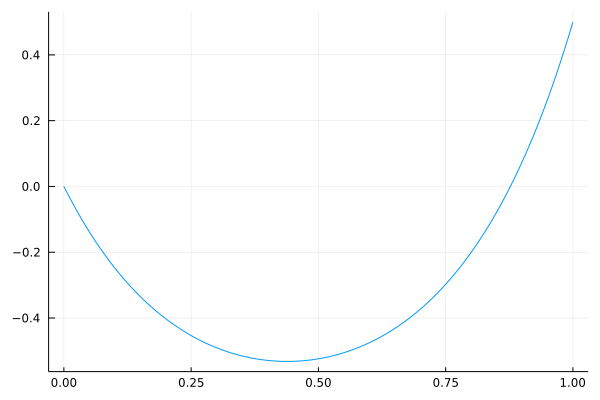

In [65]:
xvals = value.(x)
yvals = value.(y)

using Plots
plot(xvals, yvals, legend=false)